# PyTorch Modules

In [3]:
import  torch
import matplotlib.pyplot as plt
from torch import nn

## torch.nn.functional

在 `torch.nn.functional` 这个库里有许多函数可以让我们直接调用，避免重复造轮子：

- `torch.nn.functional.linear`
    - receives:    
        - X: (batch_size, in_dimensions)
        - W: (out_dimensions, in_dimensions)
        - b: (out_dimensions,) default None
    - returns:
        - output: (batch_size, out_dimensions) 

- `torch.nn.functional.relu`
    - receives:
        - X
    - returns:
        - X_after_relu

- `torch.nn.functional.conv2d`
    - receives:
        - X: (batch_size, in_channels, H, W)
        - W: (out_channels, in_channels, kH, kW)
        - b: (out_channels,) default None
        - stride: default 1   
        - padding: default 0 
    - returns:   
        output: (batch_size, out_channels, (H - kH + 2P) // S + 1, (W - kW + 2P) // S + 1)

- `torch.nn.functional.pad`
    - receives:
        - X: 
        - (left, right, up, down): padding numbers
    - returns:
        - X_padded

- `torch.nn.functional.cross_entropy`
    - receives:
        - scores: (batch_size, dimensions)
        - y: (batch_size,)
    - returns:
        - loss: scalar   
                
## torch.nn.init

在 `torch.nn.init` 这个库里有许多用于初始化的函数：

- `torch.nn.init.kaiming_normal_`
    - receives:
        - `torch.empty`: corresponding shape of W
        - nonelinearity: 'relu', 'leaky_relu', ...
    - returns:
        - W: kaming_nromal_ W
                
- `torch.nn.init.zero_`
    - receives:
        - `torch.empty`: corresponding shape of b
    - returns: 
        - b: all neurons set to zero.

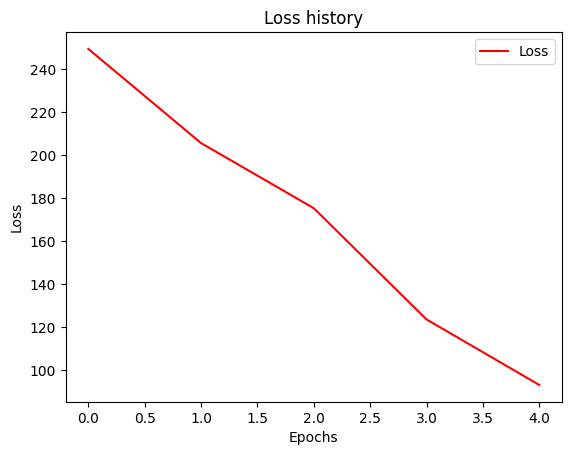

In [24]:
"""
# Conv -> ReLU -> Conv -> ReLU -> Flatten -> Linear -> ReLU -> Linear -> Softmax

Conv1: 8 filters, kernel size of 3x3, stride of 1, padding of 1
ReLU: ...
Conv2: 16 filters, kernel size of 3x3, stride of 1, padding of 1
ReLU: ...
Flatten: ...
Linear1: out dimension of 1000, in dimension of 16 * 32 * 32
Linear2: out dimension of 10, in dimension of 1000
Softmax: ...
"""

# generate training samples
X = torch.randint(0, 256, (64, 3, 32, 32), dtype=torch.float, generator=torch.Generator().manual_seed(42))
y = torch.randint(0, 10, (64,), generator=torch.Generator().manual_seed(42))

# initialize parameters
convW1 = torch.nn.init.kaiming_normal_(torch.empty(8, 3, 3, 3, requires_grad=True, dtype=torch.float))
convb1 = torch.nn.init.zeros_(torch.empty(8, requires_grad=True, dtype=torch.float))
convW2 = torch.nn.init.kaiming_normal_(torch.empty(16, 8, 3, 3, requires_grad=True, dtype=torch.float))
convb2 = torch.nn.init.zeros_(torch.empty(16, requires_grad=True, dtype=torch.float))
linarW1 = torch.nn.init.kaiming_normal_(torch.empty(1000, 16 * 32 * 32, requires_grad=True, dtype=torch.float))
linarb1 = torch.nn.init.zeros_(torch.empty(1000, requires_grad=True, dtype=torch.float))
linarW2 = torch.nn.init.kaiming_normal_(torch.empty(10, 1000, requires_grad=True, dtype=torch.float))
linarb2 = torch.nn.init.zeros_(torch.empty(10, requires_grad=True, dtype=torch.float))

loss_history = []
epochs = range(5)

for epoch in epochs:
    hidden_layer = torch.nn.functional.conv2d(X, convW1, convb1, stride=1, padding=1)
    hidden_layer = torch.nn.functional.relu(hidden_layer)
    
    hidden_layer = torch.nn.functional.conv2d(hidden_layer, convW2, convb2, stride=1, padding=1)
    hidden_layer = torch.nn.functional.relu(hidden_layer)
    hidden_layer = hidden_layer.view(hidden_layer.shape[0], -1)
    
    hidden_layer = torch.nn.functional.linear(hidden_layer, linarW1, linarb1)
    hidden_layer = torch.nn.functional.relu(hidden_layer)
    scores = torch.nn.functional.linear(hidden_layer, linarW2, linarb2)
    
    loss = torch.nn.functional.cross_entropy(scores, y)
    loss_history.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        convW1 -= 1e-5 * convW1.grad
        convb1 -= 1e-5 * convb1.grad
        convW2 -= 1e-5 * convW2.grad
        convb2 -= 1e-5 * convb2.grad
        linarW1 -= 1e-5 * linarW1.grad
        linarb1 -= 1e-5 * linarb1.grad
        linarW2 -= 1e-5 * linarW2.grad
        linarb2 -= 1e-5 * linarb2.grad
        
        convW1.grad.zero_()
        convb1.grad.zero_()
        convW2.grad.zero_()
        convb2.grad.zero_()
        linarW1.grad.zero_()
        linarb1.grad.zero_()
        linarW2.grad.zero_()
        linarb2.grad.zero_()

plt.figure()        
plt.plot(epochs, loss_history, color='red', label='Loss')
plt.legend()
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## torch.nn.Module

在以上的方法，我们需要自己手动创建一个个参数，这很麻烦，我们可以直接使用 `torch.nn.Module` 的子类来创建一个自己的网络同时避免手动创建大量参数。使用 `torch.nn.Module` 其实只用实现两个方法就行了：

- `__init__`: 在这里创建好模型需要的层，比如 `torch.nn.Conv2d`, `torch.nn.Linear` 等等，它们本身也是 `torch.nn.Modlue` 的子类。然后将层的可学习参数进行初始化 (如果该层有可学习参数的话) 。
- `forward`: 在这里使用在 `__init__` 中定义的层，决定如何向前传播. **千万不要在 `forward` 中创建新的有可学习参数的层，否则会出错，所有有可学习参数的层都必须创建在 `__init__` 中；但是可以在 `forward` 中创建新的没有可学习参数的层**。

In [21]:
class ZhihangNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # NOTE: 创建需要的层
        self.conv1 = torch.nn.Conv2d(3, 8, kernel_size=(3, 3), padding=(1, 1), stride=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=(3, 3), padding=(1, 1), stride=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(16 * 32 * 32, 1000) 
        self.relu3 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1000, 10)
        
        # NOTE: 直接将层的可学习参数传入初始化函数中
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.kaiming_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, X):
        # NOTE: 在正向传播的时候将所有的模型串联起来
        hidden_layer = self.conv1(X)
        hidden_layer = self.relu1(hidden_layer)
        hidden_layer = self.conv2(hidden_layer)
        hidden_layer = self.relu2(hidden_layer)
        hidden_layer = self.flatten(hidden_layer)
        hidden_layer = self.linear1(hidden_layer)
        hidden_layer = self.relu3(hidden_layer)
        scores = self.linear2(hidden_layer)
        return scores

## torch.optim